In [2]:
from makiflow.layers import *
from makiflow.models.segmentation.segmentator import Segmentator
from makiflow.augmentation import AffineAugment, ElasticAugment, ImageCutter, Data
from makiflow.save_recover import Builder
from makiflow.trainers import SegmentatorTrainer
from makiflow.metrics import categorical_dice_coeff, confusion_mat
import makiflow as mf

import tensorflow as tf
import numpy as np
import glob
import cv2
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter

In [3]:
def load_data(path_to_data='/mnt/data/unlabeled_med_data'):
    images = []
    images_names = glob.glob(f'{path_to_data}/*.bmp')
    images_names.sort()
    for i, img_name in enumerate(images_names):
        img = cv2.imread(img_name)
        if img is not None:
            print(f'{i}: {img_name}')
            
            mask = img[0:-100][:] > 20
            coords = np.argwhere(mask)
            y0, x0, _ = coords.min(axis=0)
            y1, x1, _ = coords.max(axis=0) + 1
            print(y0,y1, x0,x1)
            img = cv2.resize(img[y0:y1, x0:x1].copy(), (1024, 1024), interpolation=cv2.INTER_CUBIC)

            images.append(img)
    print('DONE')
    return images

In [4]:
def normalize_data(X):
    X = np.asarray(X).astype(np.float32) / 255
    X = [i for i in X]
    return X

In [ ]:
images = load_data()

In [6]:
path_to_model = '../Models/Xception_1024_testUnet_standart_V6.json'
path_to_weights = '../experiments/QuadraticCELoss_XceptionUnet(X-65)/weights.ckpt'

In [8]:
path_to_model = 'Models/Resnet50FullSizeX2.json'
path_to_weights = 'UpScale + Resnet50/experiments/Test with new class balance/MakiSegmentator_gamma=2.0_opt_name=Adam_bsz=32/last_weights/weights.ckpt'

In [7]:
images = normalize_data(images)

In [8]:
mf.set_main_gpu(1)
session = tf.Session()

In [10]:
model = Builder.segmentator_from_json(path_to_model, batch_size=1)

FileNotFoundError: [Errno 2] No such file or directory: '../Models/Xception_1024_testUnet_standart_V6.json'

In [18]:
model.set_session(session)

In [19]:
model.load_weights(path_to_weights)

INFO:tensorflow:Restoring parameters from Hypothesis 1024/experiments/First Run/MakiSegmentator_gamma=2.0_opt_name=Adam_bsz=2/epoch_10/weights.ckpt
Weights are loaded.


In [20]:
batch_sz = 1

[0 1 3 5 6 7 8 9]


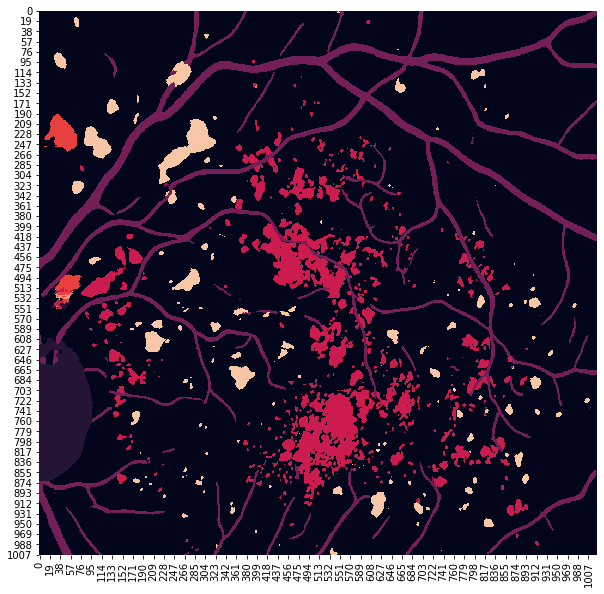

In [28]:
img_num = 3
img = images[img_num:img_num + 1]
predictions = [model.predict([cv2.resize(img[0][100:900,100:900,:], (1024, 1024))])]
predict = predictions[0][0].argmax(axis=2)
print(np.unique(predict))
fig, axs = plt.subplots(figsize=(10,10))
sns.heatmap(predict,vmin=0, vmax=10, ax=axs, cbar=False)

In [22]:
img_1 = images[0]
img_1.shape

(1024, 1024, 3)

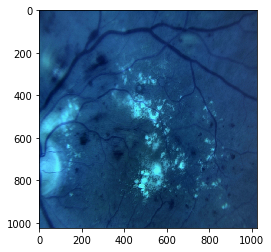

In [29]:
plt.imshow(cv2.resize(img[0][100:900,100:900,:], (1024, 1024)))

In [173]:
mask = img_1[0:-100][:] > 10
coords = np.argwhere(mask)
print(coords.min(axis=0))
y0, x0, _ = coords.min(axis=0)
y1, x1, _ = coords.max(axis=0) + 1
print(x0, y0, x1, y1)

[42  8  0]
8 42 1016 908


In [129]:
plt.imsave('1.png', img_1[50:1070, 10:1290])

In [94]:
img_1[85:1800, 18:2032].shape

(1715, 2014, 3)

In [97]:
np.array((1715, 2014, 3)) / 2

array([ 857.5, 1007. ,    1.5])

In [99]:
1024-858

166

In [100]:
1024-1007

17

In [235]:
for i in range(10):
    img_num = i
    img = images[img_num:img_num + 1]
    cv2.imwrite(f"Result/{i}/image.bmp", img[0] * 255)
    predictions = [model.predict(img)]
    predict = predictions[0][0].argmax(axis=2)
    print(np.unique(predict))
    for class_num in range(10, 100, 10):
        if np.sum(predict == class_num // 10) != 0:
         #svm = sns.heatmap(predict == class_num // 10,vmin=0, vmax=1, ax=axs, cbar=False)
         #figure = svm.get_figure()
         #figure.savefig(f"Result/{i}/{class_num}.png", dpi=200)
            cv2.imwrite(f"Result/{i}/{class_num}.bmp", np.uint8(predict == class_num // 10)*255)

[0 1 2 3 5 9]
[0 1 2 3 5 9]
[0 1 3 5 6 8 9]
[0 1 3 5 6 9]
[0 1 2 3 5 9]
[0 1 2 3 5 8 9]
[0 1 2 3 5 9]
[0 1 2 3 5 9]
[0 1 2 3 5 6 9]
[0 1 2 3 5 9]


In [240]:
for i in [10, 13, 15, 21, 31]:
    img_num = i
    img = images[img_num:img_num + 1]
    cv2.imwrite(f"Result/{i}/image.bmp", img[0] * 255)
    predictions = [model.predict(img)]
    predict = predictions[0][0].argmax(axis=2)
    print(np.unique(predict))
    for class_num in range(10, 100, 10):
        if np.sum(predict == class_num // 10) != 0:
         #svm = sns.heatmap(predict == class_num // 10,vmin=0, vmax=1, ax=axs, cbar=False)
         #figure = svm.get_figure()
         #figure.savefig(f"Result/{i}/{class_num}.png", dpi=200)
            cv2.imwrite(f"Result/{i}/{class_num}.bmp", np.uint8(predict == class_num // 10)*255)

[0 1 2 3 5 7 9]
[0 1 2 3 5 6 7 9]
[0 1 2 3 4 5 8 9]
[0 1 2 3 4 5 6 9]
[0 1 2 3 4 5 6 7 9]


In [238]:
for i in range(len(images) - 1):
    img_num = i
    img = images[img_num:img_num + 1]
    predictions = [model.predict(img)]
    predict = predictions[0][0].argmax(axis=2)
    if 4 in np.unique(predict) or 7 in np.unique(predict):
        print(i)
        print(np.unique(predict))

10
[0 1 2 3 5 7 9]
13
[0 1 2 3 5 6 7 9]
15
[0 1 2 3 4 5 8 9]
21
[0 1 2 3 4 5 6 9]
31
[0 1 2 3 4 5 6 7 9]
33
[0 1 2 3 4 5 6 8 9]
44
[0 1 2 3 5 6 7 8 9]
45
[0 1 2 3 4 5 9]
51
[0 1 2 3 5 7 9]
55
[0 1 3 5 6 7 9]
59
[0 1 2 3 5 6 7 9]
60
[0 1 2 3 5 7 8 9]
61
[0 1 2 3 5 7 8 9]
67
[0 1 3 5 6 7 9]
69
[0 1 2 3 5 7 8 9]
74
[0 1 2 3 5 7 9]
76
[0 1 2 3 4 5 8 9]
79
[0 1 2 3 5 6 7 8 9]
81
[0 1 2 3 4 5]
82
[0 1 3 5 6 7 9]
83
[0 1 3 5 6 7 9]
84
[0 1 2 3 5 7 9]
89
[0 1 2 3 4 5 9]
93
[0 1 2 3 4 5 8 9]
94
[0 1 2 3 4 5 7 8 9]
95
[0 1 2 3 4 5 6 9]
109
[0 1 2 3 5 7 8 9]
114
[0 1 2 3 5 6 7 9]
118
[0 1 2 3 4 5 6 9]
121
[0 1 2 3 5 7 9]
123
[0 1 2 3 4 5 9]
124
[0 1 2 3 5 7 8 9]
127
[0 1 2 3 4 5 9]
128
[0 1 2 3 5 7 8 9]
132
[0 1 2 3 5 6 7 9]
133
[0 1 2 3 5 6 7 9]
137
[0 1 2 3 4 5 9]
138
[0 1 2 3 4 5 7 9]
